Load Data

In [6]:

import os
import pandas as pd
import pickle
from sklearn import preprocessing

# multiclass
# filename = 'preprocess_original_label_syslog.csv'
# filename = 'original_label_syslog.csv'
# filename = 'test_binary.csv'
# filename = 'fix_1sec.csv'
filename = 'lifecycle_fix_1sec.csv'

# binary
# filename = 'label_syslog_structured.csv'

folder = os.path.join("..", "0_dataset", "syslog")
models_folder = "models_logs"
data_type = 'System Logs'


df = pd.read_csv(os.path.join(folder, filename))
df = df.loc[:, ['EventTemplate', 'Label']]

print(df.info)


# build labeling map
label_original = sorted([int(i) for i in df['Label'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
origin_to_transformed = dict(zip(le.classes_, le.transform(le.classes_)))
transformed_to_origin = dict(zip(le.transform(le.classes_), le.classes_))


X = df['EventTemplate']
X = X.to_numpy()
for i, seq in enumerate(X):
    X[i] = seq.strip(']').strip('[').split(', ')

y = df['Label']
y = y.to_numpy()
y = y.reshape(-1)
y = le.transform(y)

max_seq_length = 1550
vocab_size = 100

<bound method DataFrame.info of                                           EventTemplate  Label
0     [66, 4, 4, 4, 4, 4, 4, 4, 3, 4, 60, 68, 59, 4,...      0
1               [65, 59, 68, 60, 3, 59, 68, 66, 65, 60]      0
2     [65, 65, 65, 66, 65, 65, 3, 4, 4, 4, 4, 4, 4, ...      0
3     [66, 68, 60, 59, 68, 60, 65, 66, 65, 65, 59, 6...      0
4     [66, 4, 65, 65, 65, 65, 66, 65, 4, 4, 4, 4, 4,...      0
...                                                 ...    ...
6708  [66, 66, 70, 60, 68, 59, 65, 65, 65, 66, 65, 6...      0
6709  [4, 65, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4,...      5
6710  [3, 58, 65, 65, 66, 65, 60, 68, 59, 65, 66, 61...      0
6711  [4, 4, 3, 4, 4, 4, 59, 4, 4, 4, 4, 4, 4, 4, 4,...      5
6712  [65, 66, 65, 65, 66, 65, 59, 68, 60, 65, 66, 6...      0

[6713 rows x 2 columns]>


Define DL Models

In [7]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from tensorflow.keras import layers
from keras_self_attention import SeqSelfAttention


if tf.config.list_physical_devices('GPU'):
    print('GPU is available')
else:
    print('GPU is not available')


dl_models = {}
# deep learning
def build_BERT():
    preprocessing_layer = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)
    
    text_input = layers.Input(shape=(), dtype=tf.string)
    encoder_inputs = preprocessing_layer(text_input)
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output'] # include pooled_output & sequence_output
    net = layers.Dropout(0.3)(net)
    net = layers.Dense(len(label_original), activation='softmax')(net)
    
    return tf.keras.Model(text_input, net, name='BERT')

dl_models['RNN'] = tf.keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=16, input_length=max_seq_length),
    layers.SimpleRNN(64, return_sequences=True, dropout=0.3),
    layers.SimpleRNN(32, dropout=0.3),
    layers.Dense(len(label_original), activation='softmax'),
], name='RNN')
dl_models['LSTM'] = tf.keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=16, input_length=max_seq_length),
    layers.LSTM(64, return_sequences=True, dropout=0.3),
    layers.LSTM(32, dropout=0.3),
    layers.Dense(len(label_original), activation='softmax'),
], name='LSTM')
dl_models['Bi-LSTM'] = tf.keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=16, input_length=max_seq_length),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3)),
    layers.Bidirectional(layers.LSTM(32, dropout=0.3)),
    layers.Dense(len(label_original), activation='softmax'),
], name='Bi-LSTM')
dl_models['GRU'] = tf.keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=16, input_length=max_seq_length),
    layers.GRU(64, return_sequences=True, dropout=0.3),
    layers.GRU(32, dropout=0.3),
    layers.Dense(len(label_original), activation='softmax'),
], name='GRU')
dl_models['Bi-GRU'] = tf.keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=16, input_length=max_seq_length),
    layers.Bidirectional(layers.GRU(64, return_sequences=True, dropout=0.3)),
    layers.Bidirectional(layers.GRU(32, dropout=0.3)),
    layers.Dense(len(label_original), activation='softmax'),
], name='Bi-GRU')


# bert_models = {}
# bert_models['BERT'] = build_BERT()

for name in dl_models:
    dl_models[name].summary()
# for name in bert_models:
#     bert_models[name].summary()

GPU is available
Model: "Bi-GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1550, 16)          1600      
                                                                 
 bidirectional_2 (Bidirectio  (None, 1550, 128)        31488     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 64,582
Trainable params: 64,582
Non-trainable params: 0
_________________________________________________________________


text preprocessing

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

def tokenizing(data):
    tokenizer_filename = os.path.join(models_folder, 'tokenizer')
    if os.path.exists(tokenizer_filename):
        tokenizer = pickle.load(open(tokenizer_filename, 'rb'))
    else:
        tokenizer = Tokenizer(num_words=vocab_size)
        tokenizer.fit_on_texts(data)
        pickle.dump(tokenizer, open(tokenizer_filename, 'wb'))
    
    data_tokenized = tokenizer.texts_to_sequences(data)
    max_len = 0
    for i in data_tokenized:
        max_len = max(max_len, len(i))
    print(max_len)
    data_tokenized = pad_sequences(data_tokenized, maxlen=max_seq_length)
    print(data_tokenized.shape)
    
    return data_tokenized

tokenizing(X)

1536
(6713, 1550)


array([[0, 0, 0, ..., 7, 7, 7],
       [0, 0, 0, ..., 8, 7, 1],
       [0, 0, 0, ..., 8, 8, 7],
       ...,
       [0, 0, 0, ..., 8, 7, 7],
       [0, 0, 0, ..., 7, 6, 6],
       [0, 0, 0, ..., 8, 7, 9]])

In [9]:
# s = '[1, 2, 3]'
# s.strip(']').strip('[').split(', ')

training

In [10]:

import time
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from official.nlp import optimization
from imblearn.over_sampling import SMOTE
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
from keras.callbacks import EarlyStopping


epochs = 50
batch_size = 16
lr = 2e-5 # 5e-4, 2e-5, 3e-5
random_seed = 42


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train_tokenized = tokenizing(X_train)
X_test_tokenized = tokenizing(X_test)
# X_train, y_train = SMOTE(n_jobs=-1, random_state=random_seed).fit_resample(X_train, y_train)
print(f"original labels:{label_original}")
print(f"X_train:{len(X_train)}, y_train:{len(y_train)}")
print(f"X_test:{len(X_test)}, y_test:{len(y_test)}")


# train_steps = math.ceil(len(X_train) / batch_size)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr,
    # num_train_steps=train_steps,
    # num_warmup_steps=int(0.1*train_steps),
    # optimizer_type='adamw',
    name='adam'
)
es = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1
)
evaluation = {}
for name in dl_models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
# for name in bert_models:
#     evaluation[name] = {
#         'accuracy': [],
#         'precision': [],
#         'recall': [],
#         'f1_score': []
#     }
    
    
# training and testing
for name, model in dl_models.items():
    start_time = time.time()
    model_filename = os.path.join(models_folder, name + '.h5')
    if os.path.exists(model_filename): # load the model from disk
        model = tf.keras.models.load_model(model_filename, custom_objects=SeqSelfAttention.get_custom_objects())
    else:
        model.compile(
            loss='sparse_categorical_crossentropy', 
            # optimizer=optimizer,
            optimizer='adam',
            metrics=['sparse_categorical_accuracy']
        )
        history = model.fit(
            X_train_tokenized, y_train, 
            batch_size=batch_size, epochs=epochs, 
            validation_data=(X_test_tokenized, y_test),
            # callbacks=[es]
        )
        # plot_history(history)
        model.save(model_filename, save_format='h5')
    y_hat = model.predict(X_test_tokenized)
    y_hat = np.argmax(y_hat, axis=1) # turn one-hot format to label
    end_time = time.time()
    print("DL model: {} \nexecution time: {:.2f}\nlearning rate:{}"\
        .format(name, end_time - start_time, tf.keras.backend.eval(model.optimizer.lr)))
        
    # evaluation
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='weighted',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='weighted', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='weighted', zero_division=0))

# for name, model in bert_models.items():
#     start_time = time.time()
#     model_filename = os.path.join(models_folder, name + '.h5')
#     if os.path.exists(model_filename): # load the model from disk
#         model = tf.keras.models.load_model(model_filename, custom_objects={'KerasLayer': hub.KerasLayer})
#     else:
#         model.compile(
#             loss='sparse_categorical_crossentropy', 
#             # optimizer=optimizer,
#             optimizer='adam',
#             metrics=['sparse_categorical_accuracy']
#         )
#         history = model.fit(
#             X_train, y_train, 
#             batch_size=batch_size, epochs=epochs, 
#             validation_data=(X_test, y_test),
#             # callbacks=[es]
#         )
#         # plot_history(history)
#         model.save(model_filename, save_format='h5')
#     y_hat = model.predict(X_test)
#     y_hat = np.argmax(y_hat, axis=1) # turn one-hot format to label
#     end_time = time.time()
#     print("DL model: {} \nexecution time: {:.2f}\nlearning rate:{}"\
#         .format(name, end_time - start_time, tf.keras.backend.eval(model.optimizer.lr)))
        
#     # evaluation
#     evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
#     evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='weighted',zero_division=0))
#     evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='weighted', zero_division=0))
#     evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='weighted', zero_division=0))


1536
(5370, 1550)
1489
(1343, 1550)
original labels:[0, 1, 2, 3, 4, 5]
X_train:5370, y_train:5370
X_test:1343, y_test:1343
Epoch 1/50
336/336 [==============================] - 54s 139ms/step - loss: 1.5570 - sparse_categorical_accuracy: 0.3827 - val_loss: 1.4847 - val_sparse_categorical_accuracy: 0.4326
Epoch 2/50
336/336 [==============================] - 45s 135ms/step - loss: 1.5223 - sparse_categorical_accuracy: 0.3883 - val_loss: 1.4752 - val_sparse_categorical_accuracy: 0.4296
Epoch 3/50
336/336 [==============================] - 45s 135ms/step - loss: 1.5162 - sparse_categorical_accuracy: 0.3862 - val_loss: 1.4886 - val_sparse_categorical_accuracy: 0.4237
Epoch 4/50
336/336 [==============================] - 44s 132ms/step - loss: 1.5107 - sparse_categorical_accuracy: 0.3885 - val_loss: 1.4978 - val_sparse_categorical_accuracy: 0.4118
Epoch 5/50
336/336 [==============================] - 45s 133ms/step - loss: 1.5032 - sparse_categorical_accuracy: 0.3898 - val_loss: 1.4731 - va

evaluation

In [11]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math

def round_off(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

models = [name.replace('_', '\n') for name in evaluation]
result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(round_off(mean(value), 3))

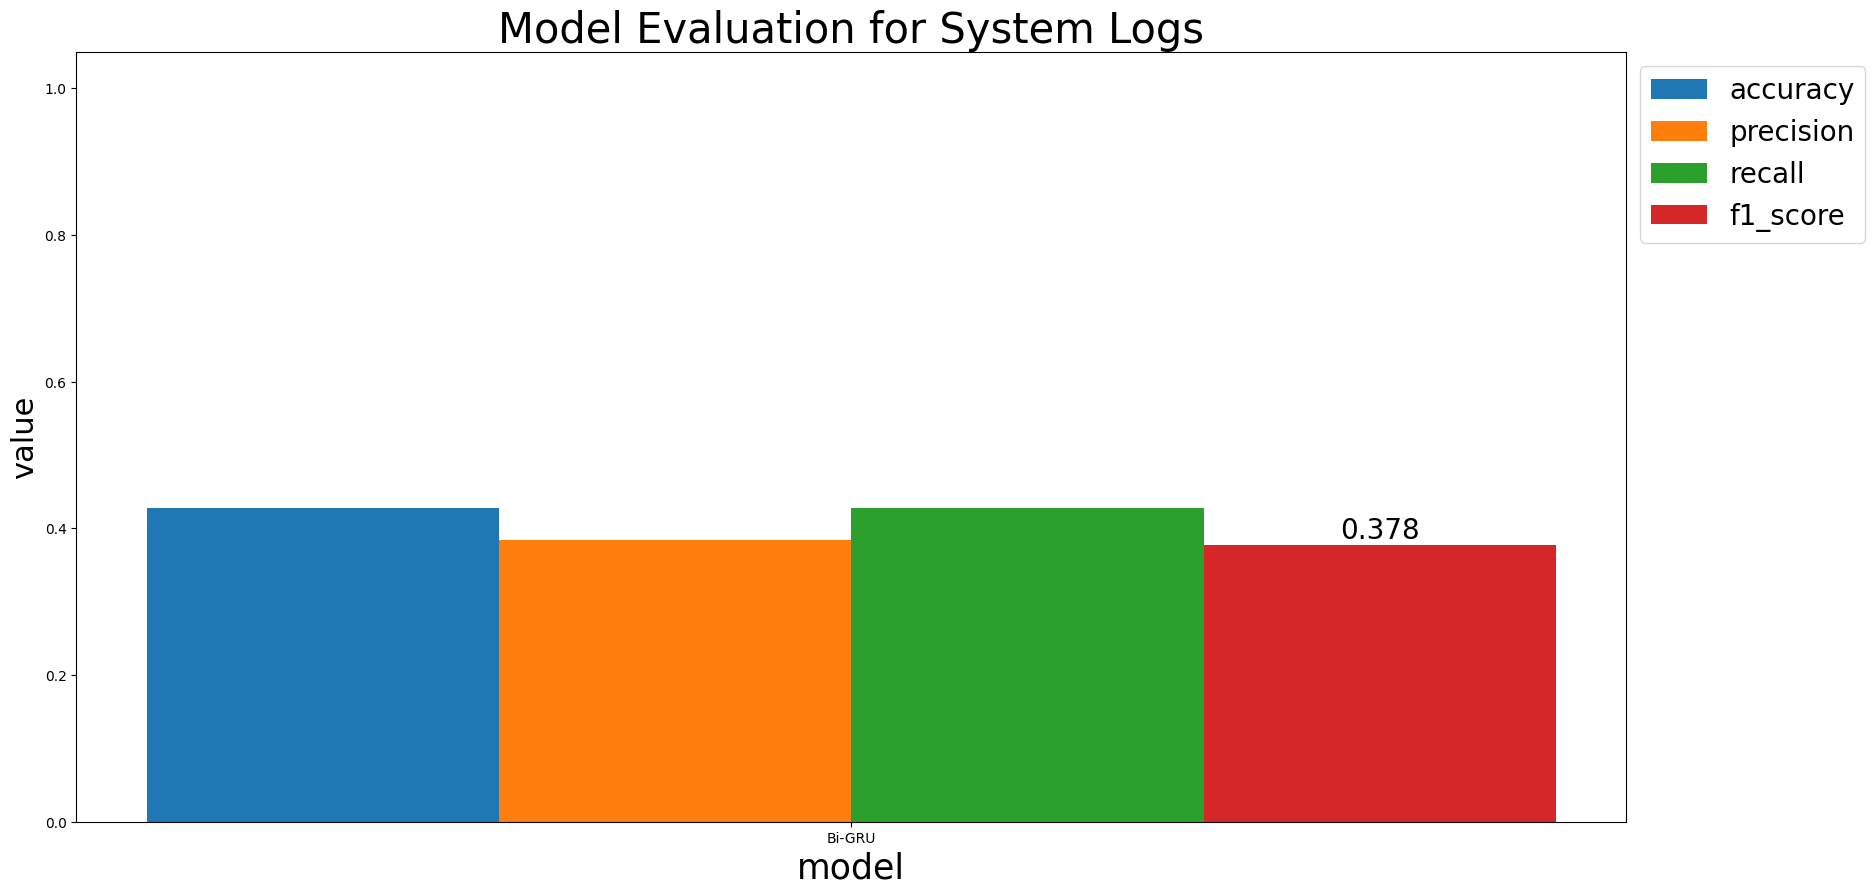

In [12]:
width = 0.2
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
plt.bar(x+width, result['precision'], width, label='precision')
plt.bar(x+2*width, result['recall'], width, label='recall')
bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=20)
plt.title('Model Evaluation for '+data_type, fontsize=30)
plt.xticks(x+1.5*width, models)
plt.xlabel('model', fontsize=25)
plt.ylabel('value', fontsize=22)
plt.rcParams.update({
    'xtick.labelsize': 18,
    'ytick.labelsize': 16,
})
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)
plt.ylim(0, 1.05)
plt.show()

confusion matrix

1489
(1343, 1550)
42/42 [==============================] - 4s 71ms/step


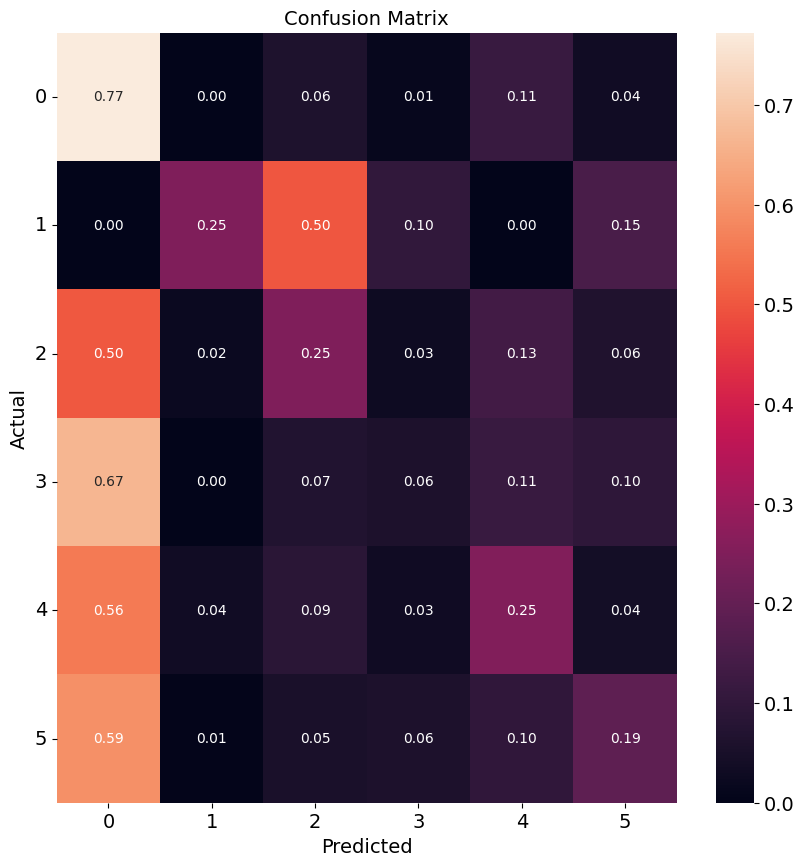

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle

name = 'Bi-GRU.h5'
model_filename = os.path.join(models_folder, name)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_names = label_original

# # BERT
# model = tf.keras.models.load_model(model_filename, custom_objects={'KerasLayer': hub.KerasLayer})
# y_hat = model.predict(X_test)
# y_hat = np.argmax(y_hat, axis=1)

# other models
model = tf.keras.models.load_model(model_filename, custom_objects=SeqSelfAttention.get_custom_objects())
X_test_tokenized = tokenizing(X_test)
y_hat = model.predict(X_test_tokenized)
y_hat = np.argmax(y_hat, axis=1)

cm = confusion_matrix(y_test, y_hat)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(block=False)

# tree.export_graphviz(model)